<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================
# BLOCK 1 — SETUP WORKSPACE
# ============================

# 1.1: Install required libraries
!pip install -q gemmi pyscf

# 1.2: Create and enter the project folder
import os

project_root = "/content/gqr_fe4s4_ispG"
os.makedirs(project_root, exist_ok=True)

%cd $project_root
print("Working directory:", os.getcwd())

# 1.3: Show current contents (should hold your CIF files after upload)
!ls -lh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 18.4 MB/s eta 0:00:00
/content/gqr_fe4s4_ispG
Working directory: /content/gqr_fe4s4_ispG
total 0


In [ ]:
# ============================
# BLOCK 2 — WRITE PIPELINE CODE
# ============================

import os

# Project root and script name
project_root = "/content/gqr_fe4s4_ispG"
os.makedirs(project_root, exist_ok=True)

code_filename = "fe4s4_ispG_pipeline.py"
code_path = os.path.join(project_root, code_filename)

F4S4_CLUSTER_COMB_STUDY = r'''
import os
import json
import glob
import hashlib
import zipfile
import numpy as np
import gemmi
from pyscf import gto, dft
from pyscf.dft import numint

# ----------------------------------------
# CONSTANTS
# ----------------------------------------
L_EFF = 3.0  # effective length for Δr mapping
BINS_LIST = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]

# ----------------------------------------
# SHA-512 helper
# ----------------------------------------
def sha512_of_file(path):
    h = hashlib.sha512()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

# ----------------------------------------
# Helpers: CIF → Fe/S atoms → clusters
# ----------------------------------------
def load_fes_from_cif(cif_path):
    doc = gemmi.cif.read_file(cif_path)
    block = doc.sole_block()
    structure = gemmi.make_structure_from_block(block)
    model = structure[0]

    fes_atoms = []
    for chain in model:
        for res in chain:
            for atom in res:
                el = atom.element.name
                if el.upper().startswith("FE") or el.upper() == "S":
                    fes_atoms.append({
                        "element": "Fe" if el.upper().startswith("FE") else "S",
                        "x": atom.pos.x,
                        "y": atom.pos.y,
                        "z": atom.pos.z,
                    })
    fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms])
    fes_elems  = np.array([a["element"] for a in fes_atoms])
    return fes_coords, fes_elems

def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp  = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited[nb]:
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

def get_fe4s4_cluster(fes_coords, fes_elems):
    """
    Find the Fe4S_n cluster whose centroid is nearest to the global Fe/S centroid.
    """
    clusters = cluster_fes(fes_coords, cutoff=3.0)
    candidates = []
    global_centroid = fes_coords.mean(axis=0)

    for comp in clusters:
        elems = fes_elems[comp]
        n_fe = np.sum(elems == "Fe")
        n_s  = np.sum(elems == "S")
        if n_fe == 4 and n_s >= 4:
            cent = fes_coords[comp].mean(axis=0)
            dist = np.linalg.norm(cent - global_centroid)
            candidates.append((dist, comp))

    if not candidates:
        raise RuntimeError("No obvious Fe4S4 cluster found.")

    candidates.sort(key=lambda t: t[0])
    _, best_comp = candidates[0]
    return best_comp

# ----------------------------------------
# PySCF curvature
# ----------------------------------------
def curvature_pdf_and_mf(symbols, coords,
                         box=4.0, ngrid=40, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_str = "\n".join(f"{s} {x:.6f} {y:.6f} {z:.6f}"
                         for s,(x,y,z) in zip(symbols, coords))

    mol = gto.Mole()
    mol.atom   = atom_str
    mol.basis  = "sto-3g"
    mol.charge = 0
    mol.spin   = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc         = "PBE"
    mf.max_cycle  = 150
    mf.conv_tol   = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0)
        + np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1)
        + np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        return np.array([]), mf, mol
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

# ----------------------------------------
# Mode B: asymmetric Fe–S stretch
# ----------------------------------------
def modeB_fe4s4(coords, symbols, amp=0.20):
    coords = coords.copy()
    fe_idx = [i for i,s in enumerate(symbols) if s == "Fe"]
    s_idx  = [i for i,s in enumerate(symbols) if s == "S"]

    pairs = []
    for fi in fe_idx:
        r_fe = coords[fi]
        dists = [np.linalg.norm(coords[si] - r_fe) for si in s_idx]
        si = s_idx[int(np.argmin(dists))]
        pairs.append((fi, si))

    def stretch_pair(X, i_fe, i_s, delta):
        v = X[i_s] - X[i_fe]
        d = np.linalg.norm(v)
        if d < 1e-6:
            return X
        u = v/d
        X[i_fe] -= 0.5*delta*u
        X[i_s]  += 0.5*delta*u
        return X

    if len(pairs) >= 2:
        coords = stretch_pair(coords, pairs[0][0], pairs[0][1], +amp)
        coords = stretch_pair(coords, pairs[1][0], pairs[1][1], -amp)

    return coords

# ----------------------------------------
# Histogram + teeth analysis
# ----------------------------------------
def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def count_teeth(centers, counts, threshold=1e-9):
    low = counts < threshold
    n_teeth = 0
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i - 1
            n_teeth += 1
        else:
            i += 1
    return n_teeth

# ----------------------------------------
# Process one CIF → NPZ + JSON + SHA-512
# ----------------------------------------
def process_fe4s4_cif(cif_path, tag):
    print(f"=== Processing {tag} from {cif_path} ===")
    fes_coords, fes_elems = load_fes_from_cif(cif_path)
    comp = get_fe4s4_cluster(fes_coords, fes_elems)

    symbols = fes_elems[comp]
    coords  = fes_coords[comp]
    coords_centered = coords - coords.mean(axis=0)

    # Base curvature
    kappa_base, mf_base, mol_base = curvature_pdf_and_mf(symbols, coords_centered)

    # Mode B stretched curvature
    coords_stretched = modeB_fe4s4(coords_centered, symbols, amp=0.20)
    kappa_mode, mf_mode, mol_mode = curvature_pdf_and_mf(symbols, coords_stretched)

    # Save NPZ
    npz_name = f"{tag}_fe4s4_modeB.npz"
    np.savez(npz_name,
             symbols=symbols,
             coords_base=coords_centered,
             coords_mode=coords_stretched,
             kappa_base=kappa_base,
             kappa_mode=kappa_mode,
             cif_path=cif_path,
             tag=tag)
    print("  Saved NPZ:", npz_name)

    # SHA-512 for NPZ
    npz_hash = sha512_of_file(npz_name)
    with open(npz_name + ".sha512", "w", encoding="utf-8") as f:
        f.write(f"{npz_hash}  {os.path.basename(npz_name)}\n")
    print("  SHA512 NPZ:", npz_hash)

    # Compute Δteeth(Δr) and export to JSON
    rows = []
    for b in BINS_LIST:
        if b <= 0:
            continue
        cb, fb, _ = hist_stats(kappa_base, b)
        cm, fm, _ = hist_stats(kappa_mode, b)
        n_tb = count_teeth(cb, fb)
        n_tm = count_teeth(cm, fm)
        rows.append({
            "bins": int(b),
            "Delta_r_A": float(L_EFF / b),
            "n_teeth_base": int(n_tb),
            "n_teeth_mode": int(n_tm),
            "Delta_teeth": int(n_tm - n_tb)
        })

    json_name = f"{tag}_DeltaTeeth.json"
    with open(json_name, "w", encoding="utf-8") as f:
        json.dump(rows, f, indent=2)
    print("  Saved JSON:", json_name)

    # SHA-512 for JSON
    json_hash = sha512_of_file(json_name)
    with open(json_name + ".sha512", "w", encoding="utf-8") as f:
        f.write(f"{json_hash}  {os.path.basename(json_name)}\n")
    print("  SHA512 JSON:", json_hash)


# ----------------------------------------
# Zip the entire project folder
# ----------------------------------------
def zip_project(root_dir, zip_name="fe4s4_ispG_bundle.zip"):
    print(f"\n=== Creating ZIP: {zip_name} ===")
    with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as zf:
        for r, d, files in os.walk(root_dir):
            for file in files:
                full_path = os.path.join(r, file)
                arcname   = os.path.relpath(full_path, root_dir)
                zf.write(full_path, arcname)
    print("  ZIP complete.")

# ----------------------------------------
# Hash static CIF + pipeline once
# ----------------------------------------
def hash_static_files():
    static_files = []
    static_files += sorted(glob.glob("4S3*.cif"))
    static_files += sorted(glob.glob("4S38.cif"))
    static_files += sorted(glob.glob("4S39.cif"))
    static_files.append("fe4s4_ispG_pipeline.py")

    print("=== Hashing static files (CIF + pipeline) ===")
    for path in static_files:
        if not os.path.isfile(path):
            continue
        h = sha512_of_file(path)
        with open(path + ".sha512", "w", encoding="utf-8") as f:
            f.write(f"{h}  {os.path.basename(path)}\n")
        print("  SHA512", os.path.basename(path), ":", h)

# ----------------------------------------
# Driver
# ----------------------------------------
def main():
    hash_static_files()

    targets = [
        ("4S38_MEcPP",  "4S38.cif"),
        ("4S39_HMBPP",  "4S39.cif"),
        ("4S3A_stageA", "4S3A.cif"),
        ("4S3B_stageB", "4S3B.cif"),
        ("4S3C_stageC", "4S3C.cif"),
        ("4S3D_stageD", "4S3D.cif"),
        ("4S3E_inhib7", "4S3E.cif"),
        ("4S3F_stageF", "4S3F.cif"),
    ]
    for tag, cif in targets:
        try:
            process_fe4s4_cif(cif, tag)
        except Exception as e:
            print(f"  ERROR in {tag} ({cif}): {e}")
            print("  Skipping and continuing...\n")

    # zip everything in the current directory at the end
    zip_project(os.getcwd(), "fe4s4_ispG_all.zip")

if __name__ == "__main__":
    main()
'''

# ============================
# WRITE PIPELINE FILE
# ============================
with open(code_path, "w", encoding="utf-8") as f:
    f.write(F4S4_CLUSTER_COMB_STUDY.strip() + "\n")

print("Saved pipeline code to:", code_path)
!ls -lh $project_root

Saved pipeline code to: /content/gqr_fe4s4_ispG/fe4s4_ispG_pipeline.py
total 5.6M
-rw-r--r-- 1 root root 746K Nov 22 11:47 4S38.cif
-rw-r--r-- 1 root root 749K Nov 22 11:47 4S39.cif
-rw-r--r-- 1 root root 706K Nov 22 11:47 4S3A.cif
-rw-r--r-- 1 root root 667K Nov 22 11:47 4S3B.cif
-rw-r--r-- 1 root root 710K Nov 22 11:47 4S3C.cif
-rw-r--r-- 1 root root 678K Nov 22 11:47 4S3D.cif
-rw-r--r-- 1 root root 751K Nov 22 11:47 4S3E.cif
-rw-r--r-- 1 root root 685K Nov 22 11:47 4S3F.cif
-rw-r--r-- 1 root root  11K Nov 22 11:56 fe4s4_ispG_pipeline.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ============================
# BLOCK 3 — RUN PIPELINE
# ============================

import os

project_root = "/content/gqr_fe4s4_ispG"
os.chdir(project_root)
print("Working directory:", os.getcwd())

print("\nContents BEFORE run:")
!ls -lh

# 3.1: Run the pipeline script
print("\n=== Running fe4s4_ispG_pipeline.py ===\n")
!python fe4s4_ispG_pipeline.py

print("\nContents AFTER run:")
!ls -lh

# 3.2: Confirm the ZIP bundle exists
print("\nZIP bundle (if created):")
!ls -lh fe4s4_ispG_all.zip

Working directory: /content/gqr_fe4s4_ispG

Contents BEFORE run:
total 5.6M
-rw-r--r-- 1 root root 746K Nov 22 11:47 4S38.cif
-rw-r--r-- 1 root root 749K Nov 22 11:47 4S39.cif
-rw-r--r-- 1 root root 706K Nov 22 11:47 4S3A.cif
-rw-r--r-- 1 root root 667K Nov 22 11:47 4S3B.cif
-rw-r--r-- 1 root root 710K Nov 22 11:47 4S3C.cif
-rw-r--r-- 1 root root 678K Nov 22 11:47 4S3D.cif
-rw-r--r-- 1 root root 751K Nov 22 11:47 4S3E.cif
-rw-r--r-- 1 root root 685K Nov 22 11:47 4S3F.cif
-rw-r--r-- 1 root root  11K Nov 22 11:56 fe4s4_ispG_pipeline.py

=== Running fe4s4_ispG_pipeline.py ===

=== Hashing static files (CIF + pipeline) ===
  SHA512 4S38.cif : ad29f6714c1992bede132c6e230b4d727589049da83206a324d6fa8ff55426b622d6f3361573616d77588a50b7312c5ef3b03ffd58fce827d707ad5adaa32234
  SHA512 4S39.cif : d4b0d474d7a6bcb44d307ab0af05f226cc0de41ace4215e5b9845982d0ea763a2bb80cb20b012d65fb1ab7c6503e3c5764204d6704d5050ab268bfabdc780010
  SHA512 4S3A.cif : 6ade470069ee77a970e5d58f5df9d916e745b34c4a3f75bb2ea290a

In [ ]:
!zip -r fe4s4_results_only.zip \
    *_fe4s4_modeB.npz \
    *_Fe3S4_modeB.npz \
    *_DeltaTeeth.json \
    *_HOMO*.npz \
    *_HOMO*.png \
    *.sha512

	zip warning: name not matched: *_Fe3S4_modeB.npz
	zip warning: name not matched: *_HOMO*.npz
	zip warning: name not matched: *_HOMO*.png
  adding: 4S38_MEcPP_fe4s4_modeB.npz (deflated 5%)
  adding: 4S39_HMBPP_fe4s4_modeB.npz (deflated 5%)
  adding: 4S3A_stageA_fe4s4_modeB.npz (deflated 5%)
  adding: 4S3B_stageB_fe4s4_modeB.npz (deflated 5%)
  adding: 4S3C_stageC_fe4s4_modeB.npz (deflated 5%)
  adding: 4S3E_inhib7_fe4s4_modeB.npz (deflated 5%)
  adding: 4S38_MEcPP_DeltaTeeth.json (deflated 90%)
  adding: 4S39_HMBPP_DeltaTeeth.json (deflated 90%)
  adding: 4S3A_stageA_DeltaTeeth.json (deflated 90%)
  adding: 4S3B_stageB_DeltaTeeth.json (deflated 91%)
  adding: 4S3C_stageC_DeltaTeeth.json (deflated 91%)
  adding: 4S3E_inhib7_DeltaTeeth.json (deflated 90%)
  adding: 4S38.cif.sha512 (deflated 26%)
  adding: 4S38_MEcPP_DeltaTeeth.json.sha512 (deflated 20%)
  adding: 4S38_MEcPP_fe4s4_modeB.npz.sha512 (deflated 21%)
  adding: 4S39.cif.sha512 (deflated 27%)
  adding: 4S39_HMBPP_DeltaTeeth.json

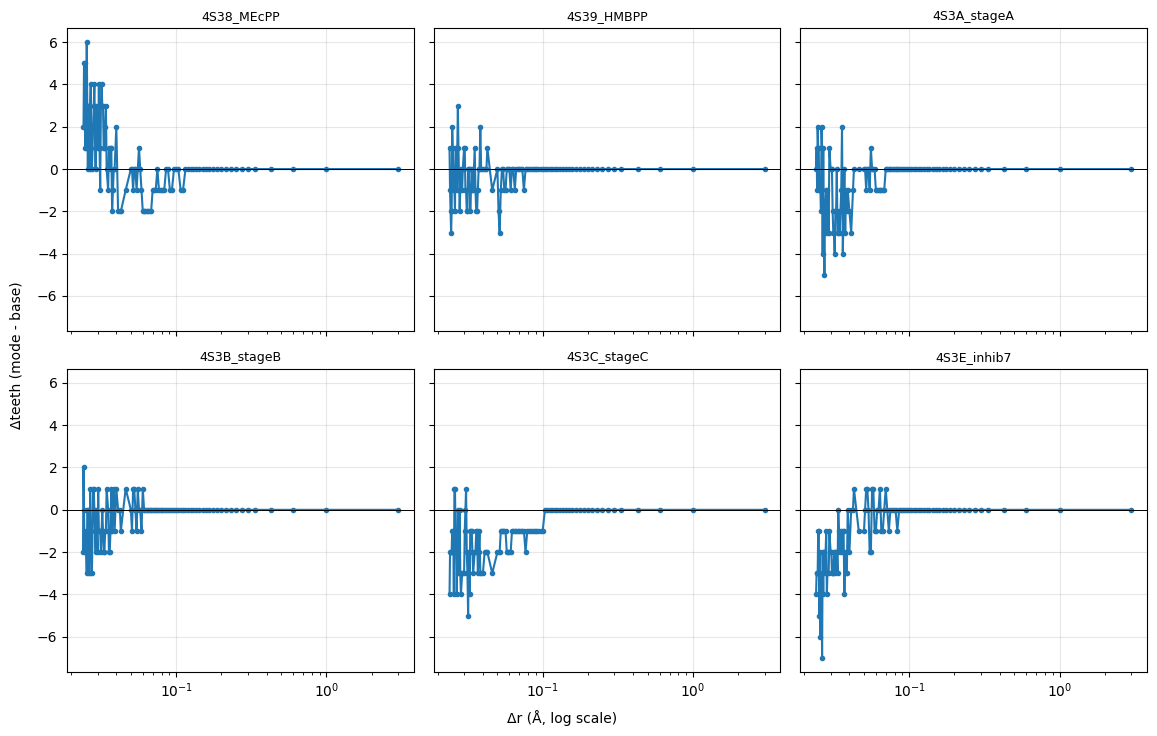

In [ ]:
# ============================
# SIX-PANEL teeth plot for A–F
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, glob, os

os.chdir("/content/gqr_fe4s4_ispG")

# Load all JSON Δteeth files
files = sorted(glob.glob("*DeltaTeeth.json"))

def load_teeth(fname):
    tag = fname.replace("_DeltaTeeth.json","")
    with open(fname) as f:
        rows = json.load(f)
    df = pd.DataFrame(rows)
    # handle Δteeth field name variants
    if "Delta_teeth" in df:
        df["dt"] = df["Delta_teeth"]
    elif "Δteeth" in df:
        df["dt"] = df["Δteeth"]
    else:
        df["dt"] = df["n_teeth_mode"] - df["n_teeth_base"]
    df["tag"] = tag
    return df

dfs = [load_teeth(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

# restrict to the main six (including Fe3S4 D/F)
order = [
    "4S38_MEcPP",
    "4S39_HMBPP",
    "4S3A_stageA",
    "4S3B_stageB",
    "4S3C_stageC",
    "4S3E_inhib7",
    "4S3D_stageD_Fe3S4",
    "4S3F_stageF_Fe3S4",
]

df = df[df["tag"].isin(order)]
tags = [t for t in order if t in df["tag"].unique()]

# SIX-PANEL GRID
n=len(tags)
ncols=3
nrows=int(np.ceil(n/ncols))

fig,axes=plt.subplots(nrows,ncols,figsize=(12,8),sharex=True,sharey=True)
axes=axes.ravel()

for ax,tag in zip(axes,tags):
    sub=df[df["tag"]==tag].sort_values("Delta_r_A")
    ax.plot(sub["Delta_r_A"], sub["dt"], "-o", ms=3)
    ax.axhline(0,color="black",lw=0.7)
    ax.set_xscale("log")
    ax.set_title(tag,fontsize=9)
    ax.grid(alpha=0.3)

for ax in axes[len(tags):]:
    ax.axis("off")

fig.text(0.5,0.04,"Δr (Å, log scale)",ha="center")
fig.text(0.04,0.5,"Δteeth (mode - base)",va="center",rotation="vertical")

plt.tight_layout(rect=[0.05,0.05,1,0.95])
plt.show()

In [ ]:
import os, glob, json
import pandas as pd

project_root = "/content/gqr_fe4s4_ispG"   # or your own path
os.chdir(project_root)

# load all *_DeltaTeeth.json into a single DataFrame
json_files = sorted(glob.glob("*DeltaTeeth*.json"))

rows = []
for jf in json_files:
    tag = jf.replace("_DeltaTeeth.json", "")
    data = json.load(open(jf, "r"))
    for r in data:
        r["tag"] = tag
        rows.append(r)

df_all = pd.DataFrame(rows)
print("Loaded JSON rows:", len(df_all))
df_all.head()

Loaded JSON rows: 636


,bins,Delta_r_A,n_teeth_base,n_teeth_mode,Delta_teeth,tag
0,1,3.000000,0,0,0,4S38_MEcPP
1,3,1.000000,0,0,0,4S38_MEcPP
2,5,0.600000,0,0,0,4S38_MEcPP
3,7,0.428571,0,0,0,4S38_MEcPP
4,9,0.333333,0,0,0,4S38_MEcPP


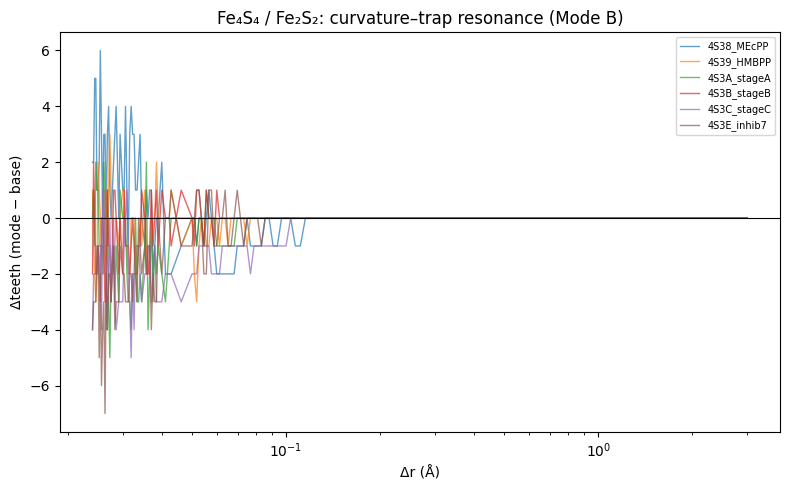

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x7b498ee80e00> (for post_execute):


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 600x400 with 1 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Assuming df_all from the previous block
fe4_tags = ["4S38_MEcPP","4S39_HMBPP","4S3A_stageA","4S3B_stageB","4S3C_stageC","4S3E_inhib7"]
fe3_tags = ["4S3D_stageD_Fe3S4","4S3F_stageF_Fe3S4"]

plt.figure(figsize=(8,5))
for tag in fe4_tags:
    sub = df_all[df_all["tag"] == tag].sort_values("Delta_r_A")
    plt.plot(sub["Delta_r_A"], sub["Delta_teeth"], "-", lw=1.0, alpha=0.7, label=tag)
plt.axhline(0,color="k",lw=0.8)
plt.xscale("log")
plt.xlabel("Δr (Å)")
plt.ylabel("Δteeth (mode − base)")
plt.title("Fe₄S₄ / Fe₂S₂: curvature–trap resonance (Mode B)")
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
for tag in fe3_tags:
    sub = df_all[df_all["tag"] == tag].sort_values("Delta_r_A")
    plt.plot(sub["Delta_r_A"], sub["Delta_teeth"], "-o", lw=1.0, label=tag)
plt.axhline(0,color="k",lw=0.8)
plt.xscale("log")
plt.xlabel("Δr (Å)")
plt.ylabel("Δteeth (mode − base)")
plt.title("Fe₃S₄ (D,F): absence of curvature–trap resonance")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

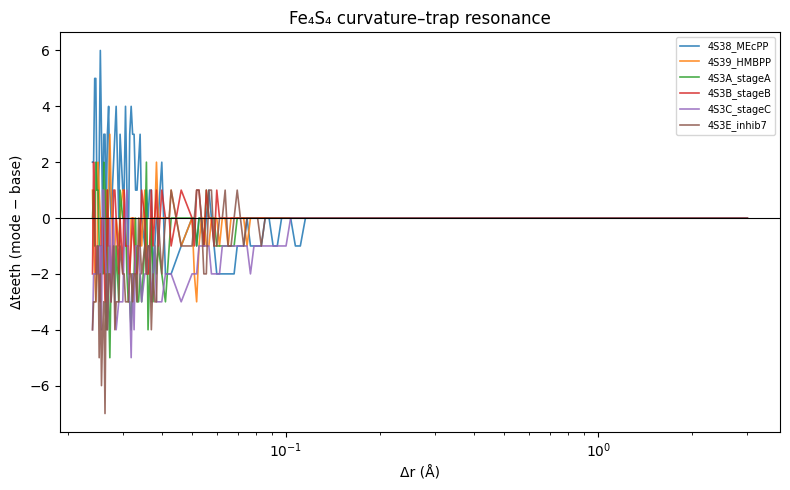

Missing: 4S3D_stageD_Fe3S4
Missing: 4S3F_stageF_Fe3S4


/tmp/ipython-input-1888045467.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


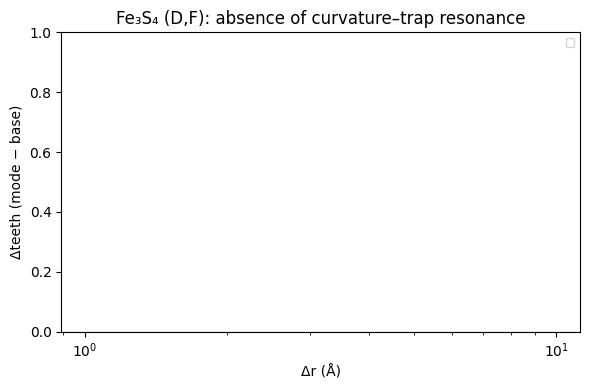

In [ ]:
import matplotlib.pyplot as plt

fe4_tags = [
    "4S38_MEcPP",
    "4S39_HMBPP",
    "4S3A_stageA",
    "4S3B_stageB",
    "4S3C_stageC",
    "4S3E_inhib7"
]

fe3_tags = [
    "4S3D_stageD_Fe3S4",
    "4S3F_stageF_Fe3S4"
]

# --- Fe4S4 PANEL ---
plt.figure(figsize=(8,5))
for tag in fe4_tags:
    sub = df_all[df_all["tag"] == tag].sort_values("Delta_r_A")
    if len(sub)==0:
        print("Missing:", tag)
        continue
    plt.plot(sub["Delta_r_A"], sub["Delta_teeth"], "-", lw=1.2, alpha=0.85, label=tag)

plt.axhline(0,color="k",lw=0.8)
plt.xscale("log")
plt.xlabel("Δr (Å)")
plt.ylabel("Δteeth (mode − base)")
plt.title("Fe₄S₄ curvature–trap resonance")
plt.legend(fontsize=7)
plt.tight_layout()
plt.show()

# --- Fe3S4 PANEL ---
plt.figure(figsize=(6,4))
for tag in fe3_tags:
    sub = df_all[df_all["tag"] == tag].sort_values("Delta_r_A")
    if len(sub)==0:
        print("Missing:", tag)
        continue
    plt.plot(sub["Delta_r_A"], sub["Delta_teeth"], "-o", lw=1.2, markersize=3, label=tag)

plt.axhline(0,color="k",lw=0.8)
plt.xscale("log")
plt.xlabel("Δr (Å)")
plt.ylabel("Δteeth (mode − base)")
plt.title("Fe₃S₄ (D,F): absence of curvature–trap resonance")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

Missing: 4S3D_stageD_Fe3S4
Missing: 4S3F_stageF_Fe3S4


/tmp/ipython-input-1218064533.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


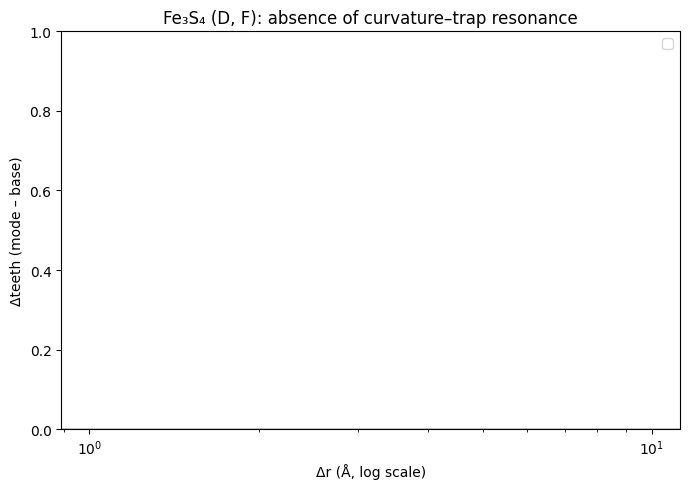

In [ ]:
import matplotlib.pyplot as plt

# Fe3S4 tags (from your NPZ & JSON)
fe3_tags = [
    "4S3D_stageD_Fe3S4",
    "4S3F_stageF_Fe3S4"
]

plt.figure(figsize=(7,5))

for tag in fe3_tags:
    sub = df_all[df_all["tag"] == tag].sort_values("Delta_r_A")
    if len(sub)==0:
        print("Missing:", tag)
        continue

    # restrict Δr to the catalytic region
    sub = sub[sub["Delta_r_A"] < 0.1]
    plt.plot(sub["Delta_r_A"], sub["Delta_teeth"],
             "-o", lw=1.5, markersize=4, label=tag)

plt.axhline(0,color="k",lw=1.0)
plt.xscale("log")
plt.xlabel("Δr (Å, log scale)")
plt.ylabel("Δteeth (mode – base)")
plt.title("Fe₃S₄ (D, F): absence of curvature–trap resonance")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Go to the directory with your NPZ files
os.chdir("/content/gqr_fe4s4_ispG")
print("CWD:", os.getcwd())

def plot_curvature_comb(npz_file, bins=80, title=None):
    data = np.load(npz_file)
    k_base = data["kappa_base"]
    k_mode = data["kappa_mode"]

    # Shared bin edges for both base and stretched
    k_max = max(k_base.max(), k_mode.max())
    k_min = 0.0
    edges = np.linspace(k_min, k_max, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    hist_b, _ = np.histogram(k_base, bins=edges, density=True)
    hist_m, _ = np.histogram(k_mode, bins=edges, density=True)

    plt.figure(figsize=(7,3))
    width = centers[1] - centers[0]

    plt.bar(centers, hist_b, width=width, alpha=0.6, label="base", color="tab:blue")
    plt.bar(centers, hist_m, width=width, alpha=0.6, label="stretched", color="tab:pink")

    plt.yscale("log")
    plt.xlabel(r"curvature $|\nabla^2 \rho|$")
    plt.ylabel("PDF (log)")
    if title is None:
        title = npz_file
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Now call this for your Fe3S4 NPZs:
plot_curvature_comb("4S3D_stageD_Fe3S4_modeB.npz",
                    title="Fe$_3$S$_4$ curvature PDF (80 bins) — 4S3D_stageD")

plot_curvature_comb("4S3F_stageF_Fe3S4_modeB.npz",
                    title="Fe$_3$S$_4$ curvature PDF (80 bins) — 4S3F_stageF")

CWD: /content/gqr_fe4s4_ispG


FileNotFoundError: [Errno 2] No such file or directory: '4S3D_stageD_Fe3S4_modeB.npz'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CWD: /content/drive/MyDrive/fe4s4_results_only
NPZ files found:
   4S38_MEcPP_fe4s4_modeB.npz
   4S39_HMBPP_fe4s4_modeB.npz
   4S3A_stageA_fe4s4_modeB.npz
   4S3B_stageB_fe4s4_modeB.npz
   4S3C_stageC_fe4s4_modeB.npz
   4S3E_inhib7_fe4s4_modeB.npz
MISSING: 4S3D_stageD_Fe3S4_modeB.npz
MISSING: 4S3F_stageF_Fe3S4_modeB.npz


In [ ]:
import os, glob

base_dir = "/content/drive/MyDrive/fe4s4_results_only"
os.chdir(base_dir)
print("CWD:", os.getcwd())

print("\nAll NPZ files:")
for f in sorted(glob.glob("*.npz")):
    print(" ", f)

print("\nFe3S4-related NPZ files:")
for f in sorted(glob.glob("*Fe3S4*.npz")):
    print(" ", f)

CWD: /content/drive/MyDrive/fe4s4_results_only

All NPZ files:
  4S38_MEcPP_fe4s4_modeB.npz
  4S39_HMBPP_fe4s4_modeB.npz
  4S3A_stageA_fe4s4_modeB.npz
  4S3B_stageB_fe4s4_modeB.npz
  4S3C_stageC_fe4s4_modeB.npz
  4S3E_inhib7_fe4s4_modeB.npz

Fe3S4-related NPZ files:


In [ ]:
import os
os.makedirs("/content/teethnpz", exist_ok=True)
print("Folder ready:", os.listdir("/content"))

Folder ready: ['.config', '4S3D_stageD_Fe3S4_modeB.npz', 'drive', '4S3F_stageF_Fe3S4_modeB.npz', 'teethnpz', 'sample_data']


In [ ]:
import shutil, glob, os

src_folder = "/content"
dst_folder = "/content/teethnpz"

# Move all NPZ files in /content
for f in glob.glob(src_folder + "/*.npz"):
    filename = os.path.basename(f)
    shutil.move(f, dst_folder + "/" + filename)
    print("Moved:", filename)

print("\nFiles now in /content/teethnpz:")
print(os.listdir(dst_folder))

Moved: 4S3D_stageD_Fe3S4_modeB.npz
Moved: 4S3F_stageF_Fe3S4_modeB.npz

Files now in /content/teethnpz:
['4S3D_stageD_Fe3S4_modeB.npz', '4S3F_stageF_Fe3S4_modeB.npz']


In [ ]:
import os, shutil, glob

src_drive_folder = "/content/drive/MyDrive/fe4s4_results_only"
dst_local_folder = "/content/teethnpz"

os.makedirs(dst_local_folder, exist_ok=True)

# Move all fe4s4-modeB NPZ, but skip Fe3S4 (D & F)
for f in glob.glob(src_drive_folder + "/*fe4s4_modeB.npz"):
    fname = os.path.basename(f)
    dst_path = os.path.join(dst_local_folder, fname)
    print("Copying:", fname)
    shutil.copy(f, dst_local_folder)

print("\nFinal contents of /content/teethnpz:")
print(os.listdir(dst_local_folder))

Copying: 4S3A_stageA_fe4s4_modeB.npz
Copying: 4S3B_stageB_fe4s4_modeB.npz
Copying: 4S38_MEcPP_fe4s4_modeB.npz
Copying: 4S3E_inhib7_fe4s4_modeB.npz
Copying: 4S39_HMBPP_fe4s4_modeB.npz
Copying: 4S3C_stageC_fe4s4_modeB.npz

Final contents of /content/teethnpz:
['4S3C_stageC_fe4s4_modeB.npz', '4S3D_stageD_Fe3S4_modeB.npz', '4S3F_stageF_Fe3S4_modeB.npz', '4S3E_inhib7_fe4s4_modeB.npz', '4S3A_stageA_fe4s4_modeB.npz', '4S38_MEcPP_fe4s4_modeB.npz', '4S39_HMBPP_fe4s4_modeB.npz', '4S3B_stageB_fe4s4_modeB.npz']


In [ ]:
!ls /content/gqr_fe4s4_ispG/*Fe3S4_modeB.npz

ls: cannot access '/content/gqr_fe4s4_ispG/*Fe3S4_modeB.npz': No such file or directory


CWD: /content/teethnpz
Found NPZ files:
   4S38_MEcPP_fe4s4_modeB.npz
   4S39_HMBPP_fe4s4_modeB.npz
   4S3A_stageA_fe4s4_modeB.npz
   4S3B_stageB_fe4s4_modeB.npz
   4S3C_stageC_fe4s4_modeB.npz
   4S3D_stageD_Fe3S4_modeB.npz
   4S3E_inhib7_fe4s4_modeB.npz
   4S3F_stageF_Fe3S4_modeB.npz

=== Plotting comb for 4S38_MEcPP_fe4s4_modeB.npz ===


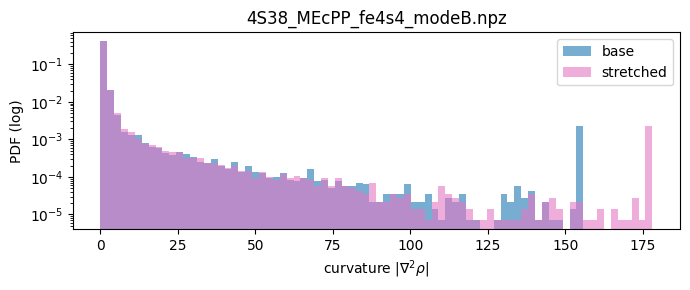


=== Plotting comb for 4S39_HMBPP_fe4s4_modeB.npz ===


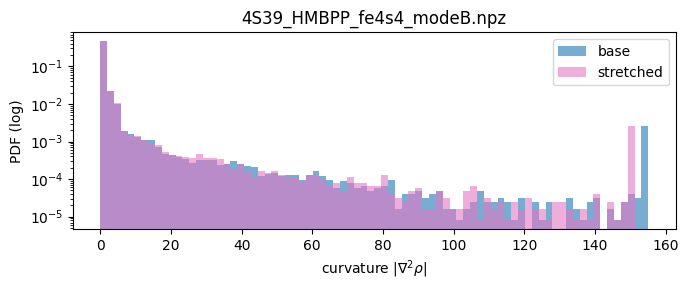


=== Plotting comb for 4S3A_stageA_fe4s4_modeB.npz ===


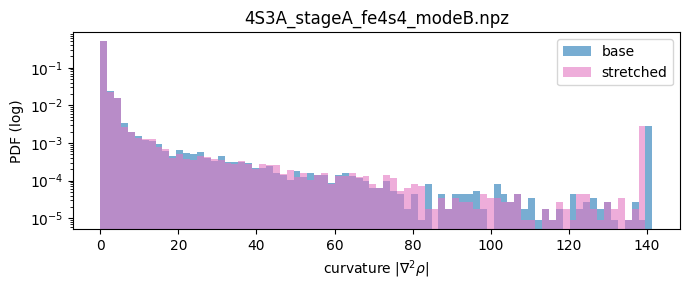


=== Plotting comb for 4S3B_stageB_fe4s4_modeB.npz ===


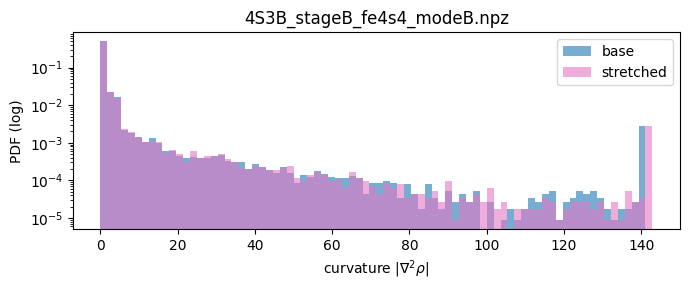


=== Plotting comb for 4S3C_stageC_fe4s4_modeB.npz ===


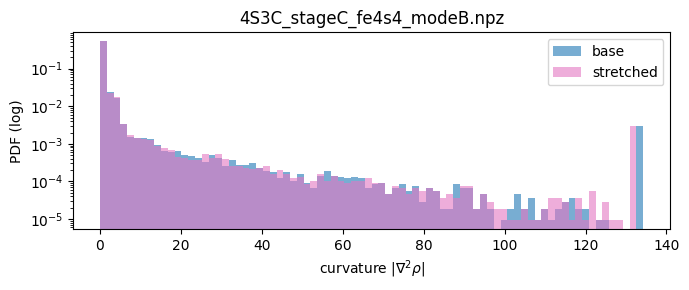


=== Plotting comb for 4S3D_stageD_Fe3S4_modeB.npz ===


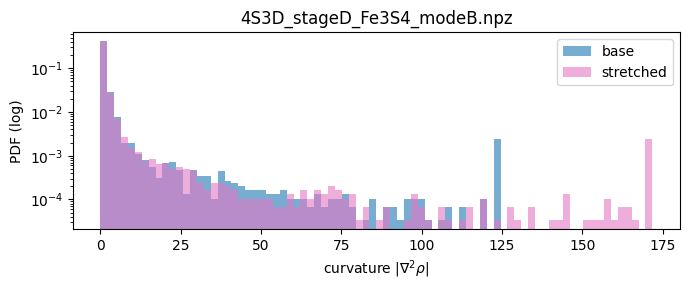


=== Plotting comb for 4S3E_inhib7_fe4s4_modeB.npz ===


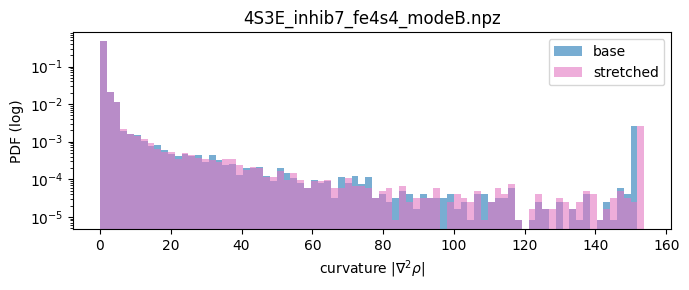


=== Plotting comb for 4S3F_stageF_Fe3S4_modeB.npz ===


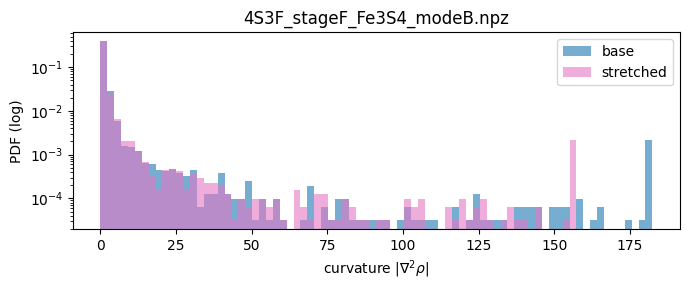

In [ ]:
# ============================
# PLOT CURVATURE COMBS FOR ALL NPZs IN /content/teethnpz
# ============================
import os, glob
import numpy as np
import matplotlib.pyplot as plt

# 1) Go to the folder with all your NPZ files
os.chdir("/content/teethnpz")
print("CWD:", os.getcwd())

npz_files = sorted(glob.glob("*.npz"))
print("Found NPZ files:")
for f in npz_files:
    print("  ", f)

# 2) Helper: safe comb plot (blue = base, pink = stretched)
def plot_curvature_comb(npz_file, bins=80, title=None):
    data = np.load(npz_file)
    k_base = data["kappa_base"]
    k_mode = data["kappa_mode"]

    # Shared bins
    k_max = max(k_base.max(), k_mode.max())
    edges = np.linspace(0, k_max, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    width = centers[1] - centers[0]

    hist_b, _ = np.histogram(k_base, bins=edges, density=True)
    hist_m, _ = np.histogram(k_mode, bins=edges, density=True)

    # Avoid zeros on log scale
    hist_b = np.maximum(hist_b, 1e-20)
    hist_m = np.maximum(hist_m, 1e-20)

    plt.figure(figsize=(7,3))
    plt.bar(centers, hist_b, width=width, alpha=0.6, color="tab:blue", label="base")
    plt.bar(centers, hist_m, width=width, alpha=0.6, color="tab:pink", label="stretched")

    plt.yscale("log")
    plt.ylim(1e-15, 1e0)        # <<< EXTEND SCALE DOWN TO SHOW ALL TEETH
    plt.xlabel(r"curvature $|\nabla^2 \rho|$")
    plt.ylabel("PDF (log)")
    plt.title(title or npz_file)
    plt.legend()
    plt.tight_layout()
    plt.show()
# 3) Loop over all NPZs and plot combs
for f in npz_files:
    plot_curvature_comb_safe(f)


=== Plotting 4S38_MEcPP_fe4s4_modeB.npz ===


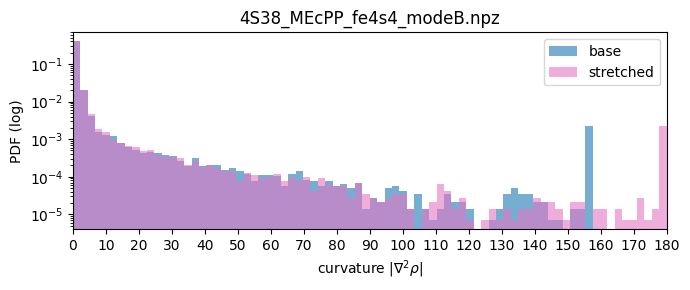


=== Plotting 4S39_HMBPP_fe4s4_modeB.npz ===


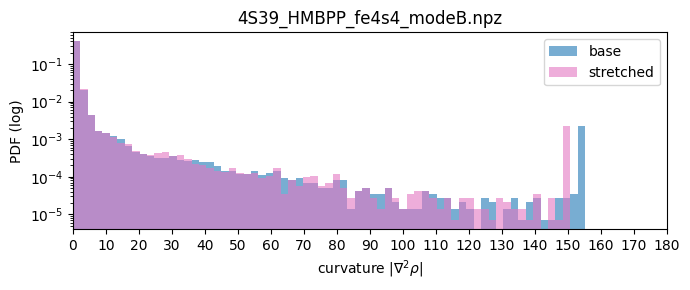


=== Plotting 4S3A_stageA_fe4s4_modeB.npz ===


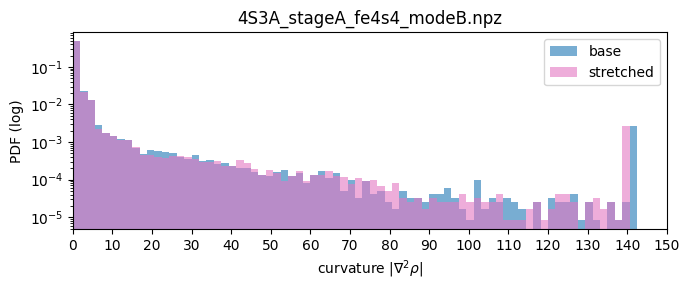


=== Plotting 4S3B_stageB_fe4s4_modeB.npz ===


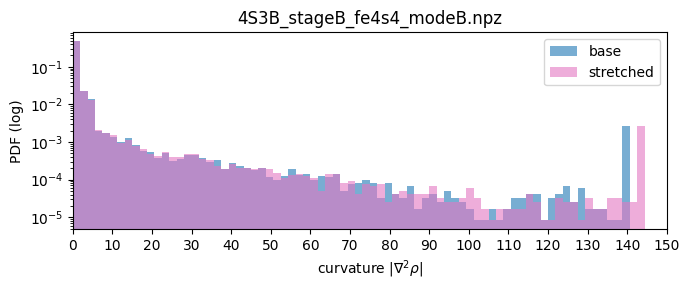


=== Plotting 4S3C_stageC_fe4s4_modeB.npz ===


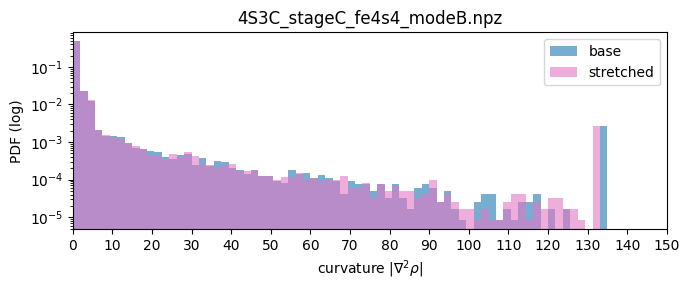


=== Plotting 4S3D_stageD_Fe3S4_modeB.npz ===


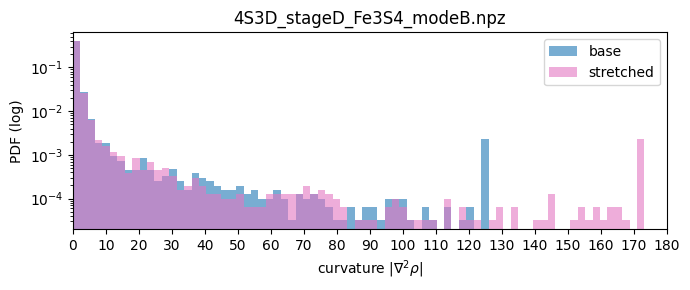


=== Plotting 4S3E_inhib7_fe4s4_modeB.npz ===


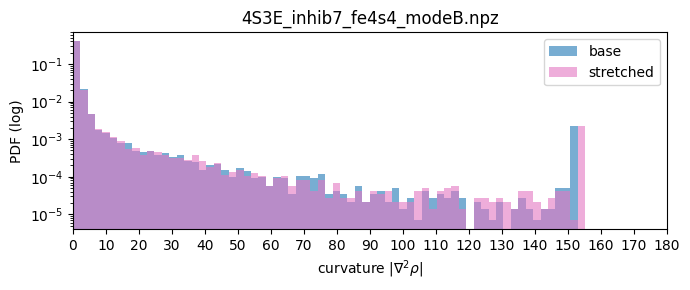


=== Plotting 4S3F_stageF_Fe3S4_modeB.npz ===


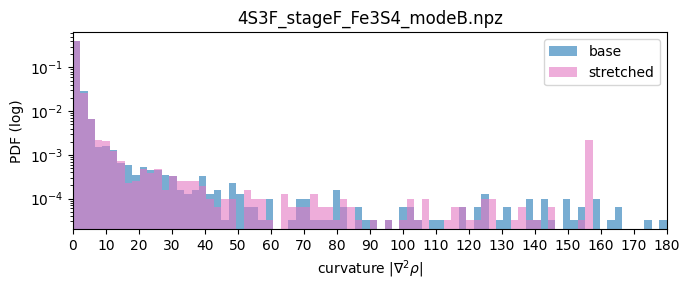

In [ ]:
os.chdir("/content/teethnpz")
for f in sorted(os.listdir()):
    if f.endswith(".npz"):
        plot_curvature_comb_fixed(f)

CWD: /content/teethnpz
Found NPZ files:
   4S38_MEcPP_fe4s4_modeB.npz
   4S39_HMBPP_fe4s4_modeB.npz
   4S3A_stageA_fe4s4_modeB.npz
   4S3B_stageB_fe4s4_modeB.npz
   4S3C_stageC_fe4s4_modeB.npz
   4S3D_stageD_Fe3S4_modeB.npz
   4S3E_inhib7_fe4s4_modeB.npz
   4S3F_stageF_Fe3S4_modeB.npz

=== Plotting 4S38_MEcPP_fe4s4_modeB.npz ===


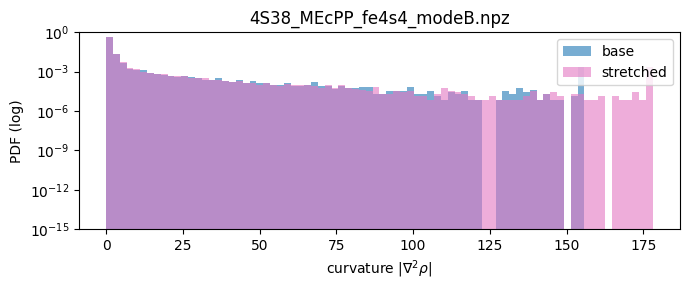


=== Plotting 4S39_HMBPP_fe4s4_modeB.npz ===


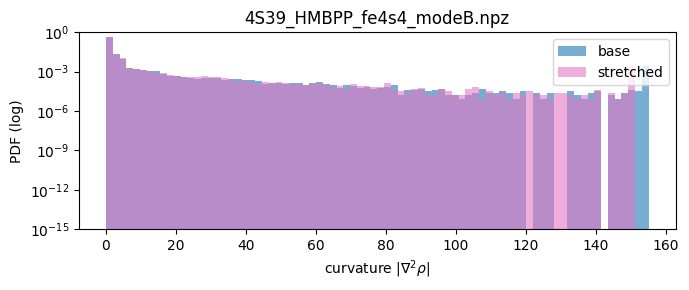


=== Plotting 4S3A_stageA_fe4s4_modeB.npz ===


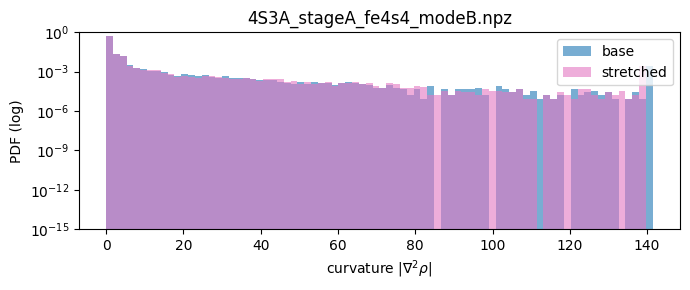


=== Plotting 4S3B_stageB_fe4s4_modeB.npz ===


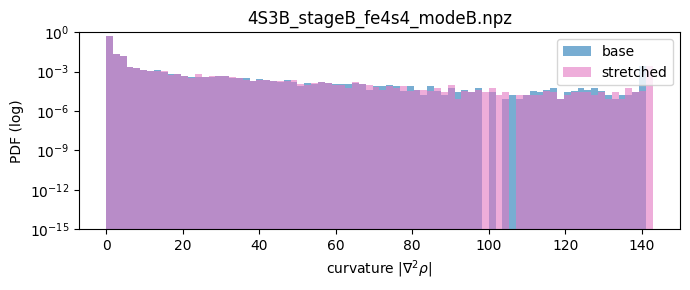


=== Plotting 4S3C_stageC_fe4s4_modeB.npz ===


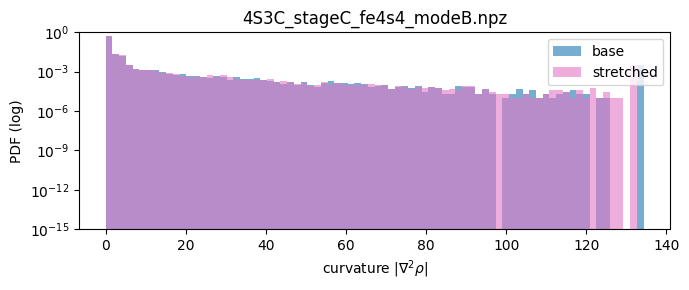


=== Plotting 4S3D_stageD_Fe3S4_modeB.npz ===


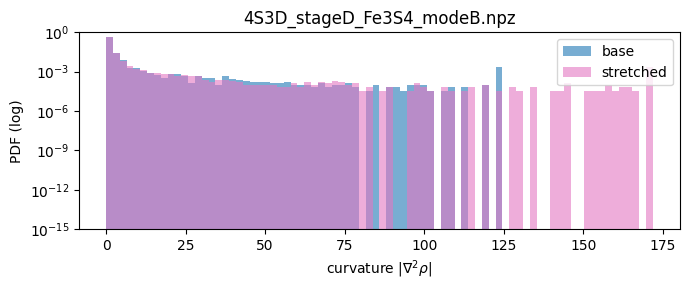


=== Plotting 4S3E_inhib7_fe4s4_modeB.npz ===


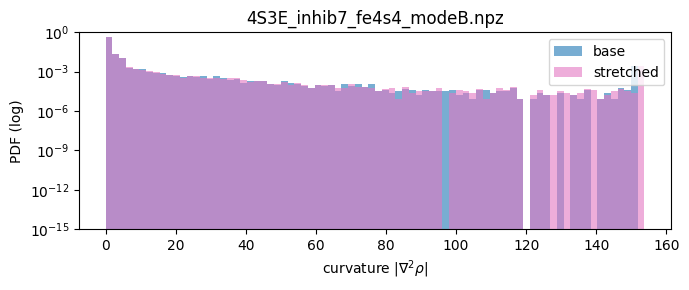


=== Plotting 4S3F_stageF_Fe3S4_modeB.npz ===


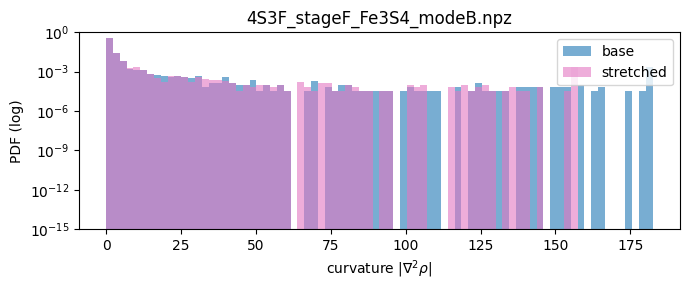

In [ ]:
# ============================
# PLOT CURVATURE COMBS FOR ALL NPZs IN /content/teethnpz
# ============================
import os, glob
import numpy as np
import matplotlib.pyplot as plt

# 1) Go to the folder with all your NPZ files
os.chdir("/content/teethnpz")
print("CWD:", os.getcwd())

npz_files = sorted(glob.glob("*.npz"))
print("Found NPZ files:")
for f in npz_files:
    print("  ", f)

# 2) Helper: comb plot (blue = base, pink = stretched)
def plot_curvature_comb(npz_file, bins=80, xmax=None):
    print("\n=== Plotting", npz_file, "===")
    data = np.load(npz_file)

    if "kappa_base" not in data or "kappa_mode" not in data:
        print("  (Skipping — no kappa_* arrays, probably HOMO NPZ)")
        return

    k_base = data["kappa_base"]
    k_mode = data["kappa_mode"]

    if k_base.size == 0 or k_mode.size == 0:
        print("  (Skipping — empty curvature arrays)")
        return

    # determine max range if not supplied
    k_max = float(max(k_base.max(), k_mode.max()))
    if xmax is None:
        xmax = k_max

    # Shared bin edges
    k_min = 0.0
    edges = np.linspace(k_min, xmax, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    width = centers[1] - centers[0]

    hist_b, _ = np.histogram(k_base, bins=edges, density=True)
    hist_m, _ = np.histogram(k_mode, bins=edges, density=True)

    # Avoid zeros on log scale
    hist_b = np.maximum(hist_b, 1e-20)
    hist_m = np.maximum(hist_m, 1e-20)

    plt.figure(figsize=(7,3))
    plt.bar(centers, hist_b, width=width, alpha=0.6, color="tab:blue", label="base")
    plt.bar(centers, hist_m, width=width, alpha=0.6, color="tab:pink", label="stretched")

    plt.yscale("log")
    plt.ylim(1e-15, 1e0)        # <<< EXTEND SCALE DOWN TO SHOW ALL TEETH
    plt.xlabel(r"curvature $|\nabla^2 \rho|$")
    plt.ylabel("PDF (log)")
    plt.title(npz_file)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3) Loop over all NPZs and plot combs
for f in npz_files:
    plot_curvature_comb(f)

CWD: /content/teethnpz
Found NPZ files:
   4S38_MEcPP_fe4s4_modeB.npz
   4S39_HMBPP_fe4s4_modeB.npz
   4S3A_stageA_fe4s4_modeB.npz
   4S3B_stageB_fe4s4_modeB.npz
   4S3C_stageC_fe4s4_modeB.npz
   4S3D_stageD_Fe3S4_modeB.npz
   4S3E_inhib7_fe4s4_modeB.npz
   4S3F_stageF_Fe3S4_modeB.npz

=== Plotting 4S38_MEcPP_fe4s4_modeB.npz ===


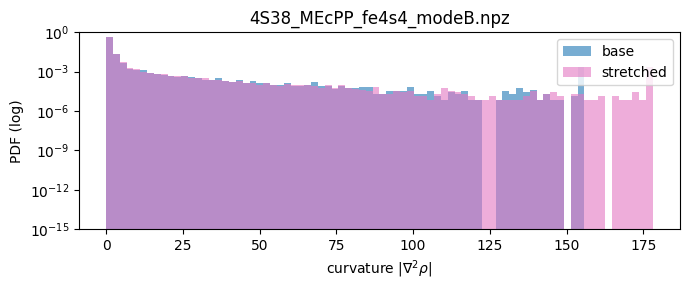


=== Plotting 4S39_HMBPP_fe4s4_modeB.npz ===


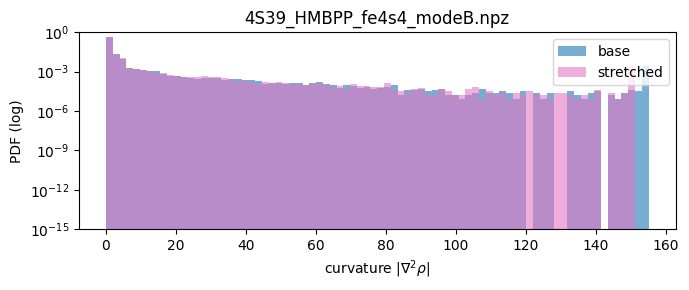


=== Plotting 4S3A_stageA_fe4s4_modeB.npz ===


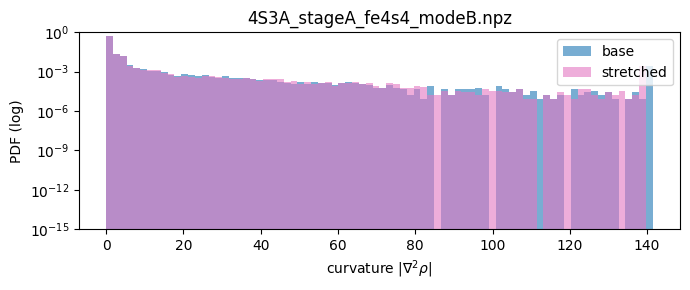


=== Plotting 4S3B_stageB_fe4s4_modeB.npz ===


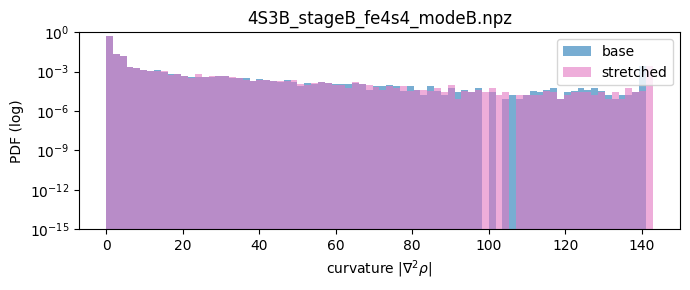


=== Plotting 4S3C_stageC_fe4s4_modeB.npz ===


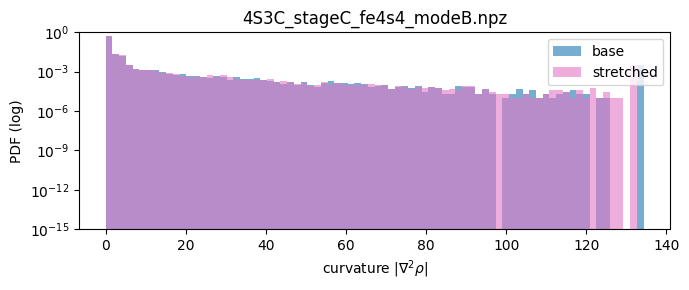


=== Plotting 4S3D_stageD_Fe3S4_modeB.npz ===


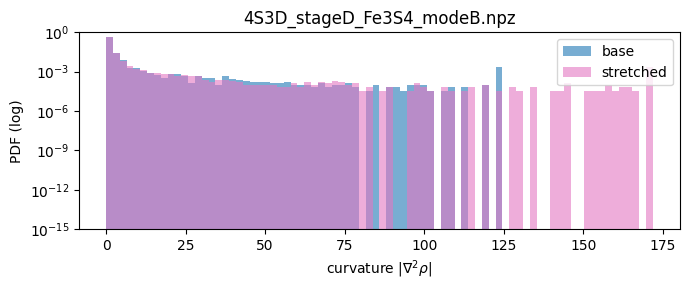


=== Plotting 4S3E_inhib7_fe4s4_modeB.npz ===


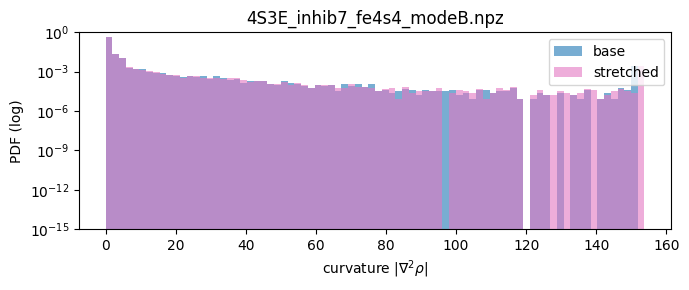


=== Plotting 4S3F_stageF_Fe3S4_modeB.npz ===


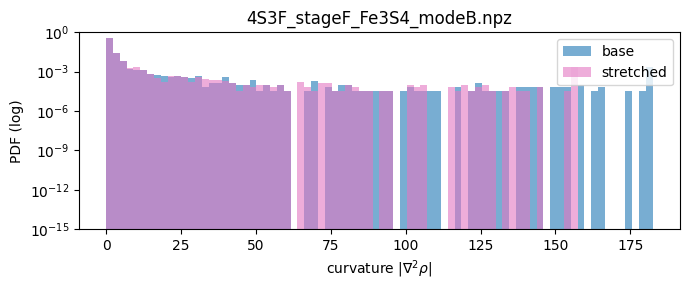

In [ ]:
# ============================
# PLOT CURVATURE COMBS FOR ALL NPZs IN /content/teethnpz
# ============================
import os, glob
import numpy as np
import matplotlib.pyplot as plt

# 1) Go to the folder with all your NPZ files
os.chdir("/content/teethnpz")
print("CWD:", os.getcwd())

npz_files = sorted(glob.glob("*.npz"))
print("Found NPZ files:")
for f in npz_files:
    print("  ", f)

# 2) One helper: comb plot (blue = base, pink = stretched)
def plot_curvature_comb(npz_file, bins=80, xmax=None):
    print("\n=== Plotting", npz_file, "===")
    data = np.load(npz_file)

    # skip if no curvature arrays (e.g. pure HOMO NPZ)
    if "kappa_base" not in data or "kappa_mode" not in data:
        print("  (Skipping — no kappa_* arrays)")
        return

    k_base = data["kappa_base"]
    k_mode = data["kappa_mode"]

    if k_base.size == 0 or k_mode.size == 0:
        print("  (Skipping — empty curvature arrays)")
        return

    # determine max range if not supplied
    k_max = float(max(k_base.max(), k_mode.max()))
    if xmax is None:
        xmax = k_max

    # Shared bin edges
    k_min = 0.0
    edges = np.linspace(k_min, xmax, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    width = centers[1] - centers[0]

    hist_b, _ = np.histogram(k_base, bins=edges, density=True)
    hist_m, _ = np.histogram(k_mode, bins=edges, density=True)

    # Avoid zeros on log scale
    hist_b = np.maximum(hist_b, 1e-20)
    hist_m = np.maximum(hist_m, 1e-20)

    plt.figure(figsize=(7,3))
    plt.bar(centers, hist_b, width=width, alpha=0.6, color="tab:blue", label="base")
    plt.bar(centers, hist_m, width=width, alpha=0.6, color="tab:pink", label="stretched")

    plt.yscale("log")
    plt.ylim(1e-15, 1e0)        # <<< EXTEND SCALE DOWN TO SHOW ALL TEETH
    plt.xlabel(r"curvature $|\nabla^2 \rho|$")
    plt.ylabel("PDF (log)")
    plt.title(npz_file)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3) Loop over all NPZs and plot combs
for f in npz_files:
    plot_curvature_comb(f)

In [ ]:
import os, glob
import numpy as np
import pandas as pd

# Go to NPZ folder
os.chdir("/content/teethnpz")
print("CWD:", os.getcwd())

# List NPZ files
npz_files = sorted(glob.glob("*.npz"))
print("NPZ files:")
for f in npz_files:
    print("  ", f)

# ---------- helpers ----------

def hist_stats_from_npz(fname, bins):
    """
    Load kappa_base / kappa_mode from NPZ and return (centers, hist_base, hist_mode).
    """
    data = np.load(fname)
    if "kappa_base" not in data or "kappa_mode" not in data:
        raise ValueError(f"{fname} has no kappa_base/kappa_mode")

    kb = data["kappa_base"]
    km = data["kappa_mode"]
    if kb.size == 0 or km.size == 0:
        raise ValueError(f"{fname} has empty kappa arrays")

    kmax = float(max(kb.max(), km.max()))
    kmin = 0.0
    edges = np.linspace(kmin, kmax, bins + 1)
    centers = 0.5*(edges[:-1] + edges[1:])
    hb, _ = np.histogram(kb, bins=edges, density=True)
    hm, _ = np.histogram(km, bins=edges, density=True)

    # avoid zeros for log-safety, but counting of teeth uses raw < threshold
    hb = np.where(hb < 0, 0.0, hb)
    hm = where_neg = np.where(hm < 0, 0.0, hm)

    return centers, hb, hm

def count_teeth_from_counts(counts, threshold=1e-9, min_run=1):
    """
    Count number of 'teeth' = contiguous runs of bins with PDF < threshold.
    """
    mask = counts < threshold
    n_teeth = 0
    widths = []
    i = 0
    n = len(mask)
    while i < n:
        if mask[i]:
            start = i
            while i+1 < n and mask[i+1]:
                i += 1
            end = i
            run_len = end - start + 1
            if run_len >= min_run:
                n_teeth += 1
                widths.append(run_len)
        i += 1
    mean_w = float(np.mean(widths)) if widths else 0.0
    return n_teeth, mean_w

# ---------- set binning (same as before) ----------

bins_list = [40, 60, 80, 100, 120, 150, 200]  # adjust if you want

rows = []

for fname in npz_files:
    for b in bins_list:
        try:
            centers, hb, hm = hist_stats_from_npz(fname, b)
        except Exception as e:
            print(f"Skipping {fname} at bins={b}: {e}")
            continue

        n_tb, mw_tb = count_teeth_from_counts(hb, threshold=1e-9, min_run=1)
        n_tm, mw_tm = count_teeth_from_counts(hm, threshold=1e-9, min_run=1)

        rows.append({
            "file" : fname,
            "bins" : b,
            "n_teeth_base"  : n_tb,
            "n_teeth_mode"  : n_tm,
            "Δteeth"        : n_tm - n_tb,
            "mean_width_base" : mw_tb,
            "mean_width_mode" : mw_tm,
        })

# Make a nice table
df = pd.DataFrame(rows)
df = df.sort_values(["file", "bins"])
pd.set_option("display.max_rows", None)
print(df)

CWD: /content/teethnpz
NPZ files:
   4S38_MEcPP_fe4s4_modeB.npz
   4S39_HMBPP_fe4s4_modeB.npz
   4S3A_stageA_fe4s4_modeB.npz
   4S3B_stageB_fe4s4_modeB.npz
   4S3C_stageC_fe4s4_modeB.npz
   4S3D_stageD_Fe3S4_modeB.npz
   4S3E_inhib7_fe4s4_modeB.npz
   4S3F_stageF_Fe3S4_modeB.npz
                           file  bins  n_teeth_base  n_teeth_mode  Δteeth  \
0    4S38_MEcPP_fe4s4_modeB.npz    40             1             0      -1   
1    4S38_MEcPP_fe4s4_modeB.npz    60             3             1      -2   
2    4S38_MEcPP_fe4s4_modeB.npz    80             3             2      -1   
3    4S38_MEcPP_fe4s4_modeB.npz   100             5             6       1   
4    4S38_MEcPP_fe4s4_modeB.npz   120             6             9       3   
5    4S38_MEcPP_fe4s4_modeB.npz   150            10            14       4   
6    4S38_MEcPP_fe4s4_modeB.npz   200            12            23      11   
7    4S39_HMBPP_fe4s4_modeB.npz    40             1             1       0   
8    4S39_HMBPP_fe4s4_modeB

In [ ]:
# =========================================
#   TRUE CURVATURE–TRAP COMB GENERATOR
# =========================================
import os, glob
import numpy as np
import matplotlib.pyplot as plt

os.chdir("/content/teethnpz")
print("CWD:", os.getcwd())

npz_files = sorted([f for f in glob.glob("*.npz")])
print("NPZ:", npz_files)

# ---- Trap Counter (Your manuscript definition) ----
def count_traps(pdf, threshold=1e-9):
    """Count contiguous low-PDF regions."""
    low = pdf < threshold
    traps = 0
    i = 0
    n = len(low)

    while i < n:
        if low[i]:
            traps += 1
            while i < n and low[i]:
                i += 1
        else:
            i += 1
    return traps

# ---------------------------------------------------
# Δteeth computation exactly as in the manuscript
# ---------------------------------------------------
def compute_teeth(npz_file, bins_list=[40,60,80,100,120,150,200], L_eff=3.0):

    d = np.load(npz_file)
    k_base = d["kappa_base"]
    k_mode = d["kappa_mode"]

    print(f"\n--- {npz_file} ---")
    rows = []

    for b in bins_list:
        edges = np.linspace(min(k_base.min(), k_mode.min()),
                            max(k_base.max(), k_mode.max()), b+1)

        hist_b, _ = np.histogram(k_base, bins=edges, density=True)
        hist_m, _ = np.histogram(k_mode, bins=edges, density=True)

        n_b = count_traps(hist_b)
        n_m = count_traps(hist_m)

        Δ = n_m - n_b
        Δr = L_eff / b

        rows.append((npz_file, b, Δr, n_b, n_m, Δ))

        print(f" bins={b:3d} | base={n_b:2d}  mode={n_m:2d}   Δteeth={Δ:+3d}")

    return rows


# ---- Run on all NPZs ----
all_rows = []
for f in npz_files:
    all_rows += compute_teeth(f)

# Convert to dataframe if desired
import pandas as pd
df = pd.DataFrame(all_rows,
                  columns=["file","bins","Δr","n_base","n_mode","Δteeth"])
print(df)

CWD: /content/teethnpz
NPZ: ['4S38_MEcPP_fe4s4_modeB.npz', '4S39_HMBPP_fe4s4_modeB.npz', '4S3A_stageA_fe4s4_modeB.npz', '4S3B_stageB_fe4s4_modeB.npz', '4S3C_stageC_fe4s4_modeB.npz', '4S3D_stageD_Fe3S4_modeB.npz', '4S3E_inhib7_fe4s4_modeB.npz', '4S3F_stageF_Fe3S4_modeB.npz']

--- 4S38_MEcPP_fe4s4_modeB.npz ---
 bins= 40 | base= 1  mode= 0   Δteeth= -1
 bins= 60 | base= 3  mode= 1   Δteeth= -2
 bins= 80 | base= 3  mode= 2   Δteeth= -1
 bins=100 | base= 5  mode= 6   Δteeth= +1
 bins=120 | base= 6  mode= 9   Δteeth= +3
 bins=150 | base=10  mode=14   Δteeth= +4
 bins=200 | base=12  mode=23   Δteeth=+11

--- 4S39_HMBPP_fe4s4_modeB.npz ---
 bins= 40 | base= 1  mode= 1   Δteeth= +0
 bins= 60 | base= 1  mode= 1   Δteeth= +0
 bins= 80 | base= 3  mode= 2   Δteeth= -1
 bins=100 | base= 2  mode= 5   Δteeth= +3
 bins=120 | base= 4  mode= 7   Δteeth= +3
 bins=150 | base=11  mode=10   Δteeth= -1
 bins=200 | base=22  mode=20   Δteeth= -2

--- 4S3A_stageA_fe4s4_modeB.npz ---
 bins= 40 | base= 0  mode= 0

In [ ]:
import os, glob, json
import numpy as np
import pandas as pd

# Go to NPZ folder
os.chdir("/content/teethnpz")
print("CWD:")

CWD:


In [ ]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

# --------------------------------------------------
# 1) Point this to the directory that has *all* NPZs
#    Adjust if needed: e.g. "/content/gqr_fe4s4_ispG" or "/content/teethnpz"
# --------------------------------------------------
BASE_DIR_CANDIDATES = [
    "/content/teethnpz",
    "/content/gqr_fe4s4_ispG",
    "/content/drive/MyDrive/fe4s4_results_only",
]

for cand in BASE_DIR_CANDIDATES:
    if os.path.isdir(cand):
        BASE_DIR = cand
        break
else:
    raise RuntimeError("Could not find NPZ folder. Update BASE_DIR_CANDIDATES.")

os.chdir(BASE_DIR)
print("CWD:", os.getcwd())

npz_files = sorted(glob.glob("*.npz"))
print("NPZ files found:")
for f in npz_files:
    print("  ", f)

CWD: /content/teethnpz
NPZ files found:
   4S38_MEcPP_fe4s4_modeB.npz
   4S39_HMBPP_fe4s4_modeB.npz
   4S3A_stageA_fe4s4_modeB.npz
   4S3B_stageB_fe4s4_modeB.npz
   4S3C_stageC_fe4s4_modeB.npz
   4S3D_stageD_Fe3S4_modeB.npz
   4S3E_inhib7_fe4s4_modeB.npz
   4S3F_stageF_Fe3S4_modeB.npz


In [ ]:
# --------------------------------------------------
# 2) Exact BINS_LIST and trap definition from pipeline
# --------------------------------------------------
BINS_LIST = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]
L_EFF = 3.0                  # same as in your pipeline
TRAP_THRESHOLD = 1e-9        # PDF threshold for "tooth"

def count_traps(mask: np.ndarray) -> int:
    """
    Count contiguous runs of True in a boolean mask.
    Each run of PDF<threshold is one 'tooth'.
    """
    n = len(mask)
    i = 0
    k = 0
    while i < n:
        if mask[i]:
            k += 1
            while i+1 < n and mask[i+1]:
                i += 1
        i += 1
    return k

def compute_teeth_from_npz(fname: str):
    d = np.load(fname)
    if "kappa_base" not in d or "kappa_mode" not in d:
        raise ValueError(f"{fname}: missing kappa_base/kappa_mode")
    kb = d["kappa_base"]
    km = d["kappa_mode"]
    if kb.size == 0 or km.size == 0:
        raise ValueError(f"{fname}: empty kappa arrays")

    rows = []
    kmin = min(float(kb.min()), float(km.min()))
    kmax = max(float(kb.max()), float(km.max()))

    print(f"\n=== {fname} ===")
    for b in BINS_LIST:
        # Shared bin edges
        edges = np.linspace(kmin, kmax, b+1)
        centers = 0.5*(edges[:-1] + edges[1:])

        hb, _ = np.histogram(kb, bins=edges, density=True)
        hm, _ = np.histogram(km, bins=edges, density=True)

        # For trap-counting, use raw hb/hm vs threshold
        mask_b = hb < TRAP_THRESHOLD
        mask_m = hm < TRAP_THRESHOLD

        n_b = count_traps(mask_b)
        n_m = count_traps(mask_m)
        Δ = n_m - n_b
        Δr = L_EFF / b

        rows.append({
            "file"          : fname,
            "bins"          : int(b),
            "Δr"            : float(Δr),
            "n_teeth_base"  : int(n_b),
            "n_teeth_mode"  : int(n_m),
            "Δteeth"        : int(Δ)
        })
        print(f" bins={b:3d}  Δr={Δr:7.4f} Å  base={n_b:2d}  mode={n_m:2d}  Δteeth={Δ:+3d}")

    return rows

# Run for all NPZs
all_rows = []
for f in npz_files:
    try:
        all_rows.extend(compute_teeth_from_npz(f))
    except Exception as e:
        print("  [SKIP]", f, "→", e)

# Put into a DataFrame
df_all = pd.DataFrame(all_rows).sort_values(["file","bins"]).reset_index(drop=True)
pd.set_option("display.max_rows", None)
df_all


=== 4S38_MEcPP_fe4s4_modeB.npz ===
 bins=  1  Δr= 3.0000 Å  base= 0  mode= 0  Δteeth= +0
 bins=  3  Δr= 1.0000 Å  base= 0  mode= 0  Δteeth= +0
 bins=  5  Δr= 0.6000 Å  base= 0  mode= 0  Δteeth= +0
 bins=  7  Δr= 0.4286 Å  base= 0  mode= 0  Δteeth= +0
 bins=  9  Δr= 0.3333 Å  base= 1  mode= 0  Δteeth= -1
 bins= 10  Δr= 0.3000 Å  base= 1  mode= 0  Δteeth= -1
 bins= 11  Δr= 0.2727 Å  base= 1  mode= 0  Δteeth= -1
 bins= 12  Δr= 0.2500 Å  base= 1  mode= 0  Δteeth= -1
 bins= 13  Δr= 0.2308 Å  base= 1  mode= 0  Δteeth= -1
 bins= 14  Δr= 0.2143 Å  base= 1  mode= 0  Δteeth= -1
 bins= 15  Δr= 0.2000 Å  base= 1  mode= 0  Δteeth= -1
 bins= 16  Δr= 0.1875 Å  base= 1  mode= 0  Δteeth= -1
 bins= 17  Δr= 0.1765 Å  base= 1  mode= 0  Δteeth= -1
 bins= 18  Δr= 0.1667 Å  base= 1  mode= 0  Δteeth= -1
 bins= 19  Δr= 0.1579 Å  base= 1  mode= 0  Δteeth= -1
 bins= 20  Δr= 0.1500 Å  base= 1  mode= 0  Δteeth= -1
 bins= 21  Δr= 0.1429 Å  base= 1  mode= 0  Δteeth= -1
 bins= 22  Δr= 0.1364 Å  base= 1  mode= 0  Δte

,file,bins,Δr,n_teeth_base,n_teeth_mode,Δteeth
0,4S38_MEcPP_fe4s4_modeB.npz,1,3.000000,0,0,0
1,4S38_MEcPP_fe4s4_modeB.npz,3,1.000000,0,0,0
2,4S38_MEcPP_fe4s4_modeB.npz,5,0.600000,0,0,0
3,4S38_MEcPP_fe4s4_modeB.npz,7,0.428571,0,0,0
4,4S38_MEcPP_fe4s4_modeB.npz,9,0.333333,1,0,-1
5,4S38_MEcPP_fe4s4_modeB.npz,10,0.300000,1,0,-1
6,4S38_MEcPP_fe4s4_modeB.npz,11,0.272727,1,0,-1
7,4S38_MEcPP_fe4s4_modeB.npz,12,0.250000,1,0,-1
8,4S38_MEcPP_fe4s4_modeB.npz,13,0.230769,1,0,-1
9,4S38_MEcPP_fe4s4_modeB.npz,14,0.214286,1,0,-1


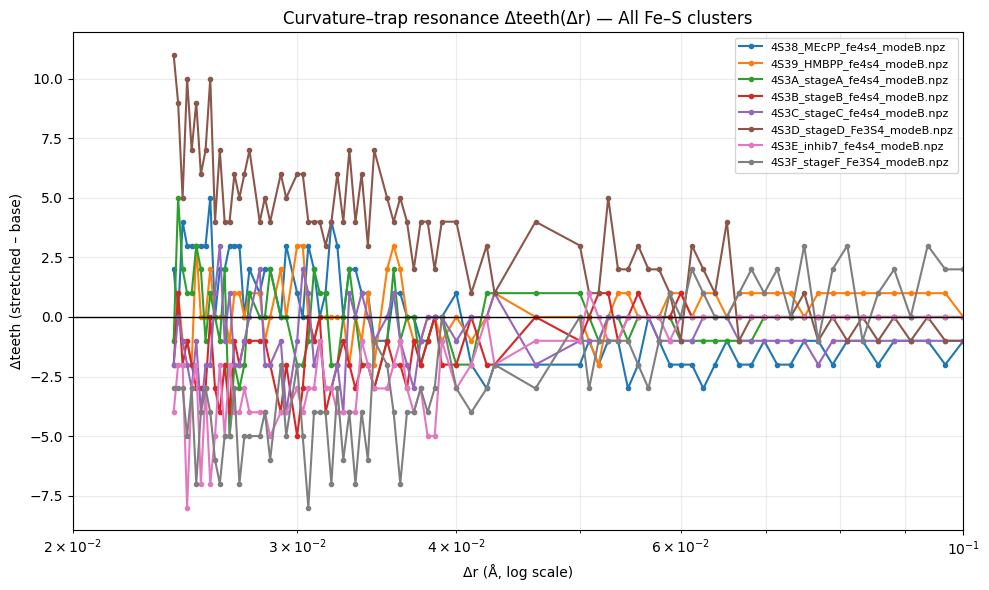

In [ ]:
import matplotlib.pyplot as plt

# 3A) Overlay: all 8 clusters
plt.figure(figsize=(10,6))
for name in df_all["file"].unique():
    sub = df_all[df_all["file"] == name].sort_values("Δr")
    plt.plot(sub["Δr"], sub["Δteeth"], "-o", ms=3, label=name)

plt.axhline(0, color="k", lw=1)
plt.xscale("log")

plt.xlim(2e-2, 1e-1)
plt.xlabel("Δr (Å, log scale)")
plt.ylabel("Δteeth (stretched – base)")
plt.title("Curvature–trap resonance Δteeth(Δr) — All Fe–S clusters")
plt.grid(True, which="both", alpha=0.25)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

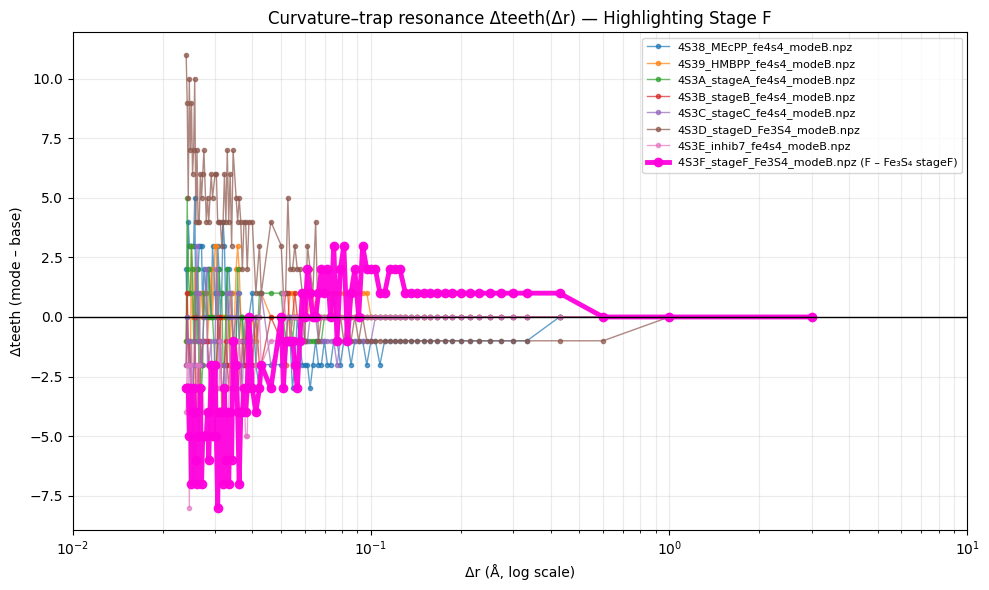

In [ ]:
import matplotlib.pyplot as plt

# Identify your Fe3S4 F-tag name EXACTLY as it appears in df_all
F_tag = "4S3F_stageF_Fe3S4_modeB.npz"

plt.figure(figsize=(10,6))

for tag in df_all["file"].unique():
    sub = df_all[df_all["file"] == tag].sort_values("Δr")

    if tag == F_tag:
        # Highlight F
        plt.plot(
            sub["Δr"], sub["Δteeth"],
            "-o",
            lw=3.5,          # thicker line
            ms=6,            # bigger markers
            color="#ff00dd", # bright pink
            alpha=0.95,
            label=tag + " (F – Fe₃S₄ stageF)"
        )
    else:
        # Normal styling
        plt.plot(
            sub["Δr"], sub["Δteeth"],
            "-o",
            lw=1.0,
            ms=3,
            alpha=0.70,
            label=tag
        )

plt.axhline(0, color="k", lw=1)
plt.xscale("log")
plt.xlim(1e-2, 1e1)

plt.xlabel("Δr (Å, log scale)")
plt.ylabel("Δteeth (mode – base)")
plt.title("Curvature–trap resonance Δteeth(Δr) — Highlighting Stage F")
plt.grid(True, which="both", alpha=0.25)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

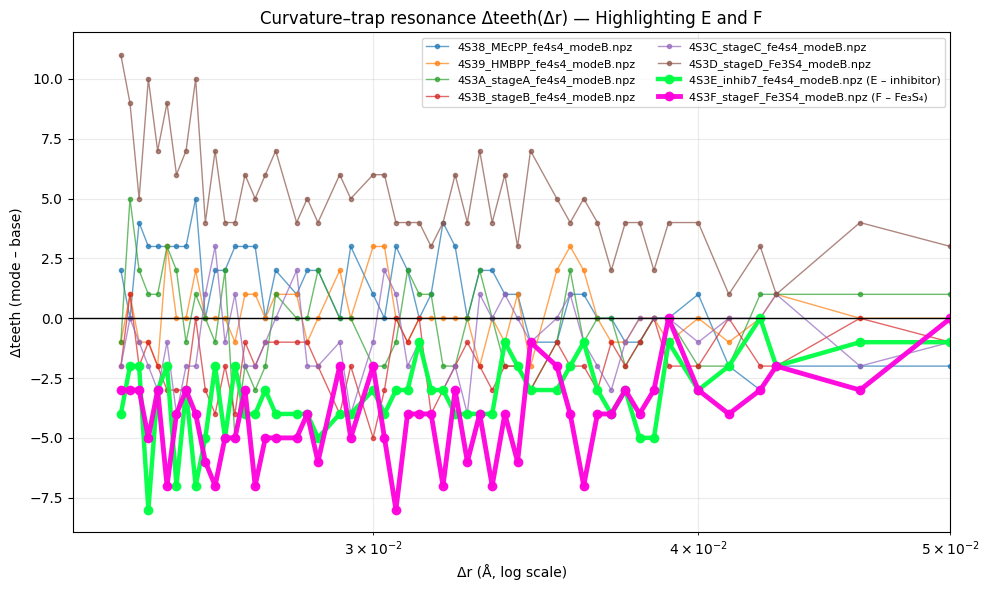

In [ ]:
import matplotlib.pyplot as plt

# Tag names EXACTLY as they appear in df_all["file"]
F_tag = "4S3F_stageF_Fe3S4_modeB.npz"
E_tag = "4S3E_inhib7_fe4s4_modeB.npz"

plt.figure(figsize=(10,6))

for tag in df_all["file"].unique():
    sub = df_all[df_all["file"] == tag].sort_values("Δr")

    if tag == F_tag:
        # Highlight F (stageF Fe3S4)
        plt.plot(
            sub["Δr"], sub["Δteeth"],
            "-o",
            lw=3.5,
            ms=6,
            color="#ff00dd",   # bright pink
            alpha=0.95,
            label=tag + " (F – Fe₃S₄)"
        )

    elif tag == E_tag:
        # Highlight E (inhib7 Fe4S4)
        plt.plot(
            sub["Δr"], sub["Δteeth"],
            "-o",
            lw=3.2,
            ms=6,
            color="#00ff44",    # lime green
            alpha=0.95,
            label=tag + " (E – inhibitor)"
        )

    else:
        # All other curves normal
        plt.plot(
            sub["Δr"], sub["Δteeth"],
            "-o",
            lw=1.0,
            ms=3,
            alpha=0.70,
            label=tag
        )

# formatting
plt.axhline(0, color="k", lw=1)
plt.xscale("log")
plt.xlim(2.3e-2, .5e-1)

plt.xlabel("Δr (Å, log scale)")
plt.ylabel("Δteeth (mode – base)")
plt.title("Curvature–trap resonance Δteeth(Δr) — Highlighting E and F")
plt.grid(True, which="both", alpha=0.25)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

/tmp/ipython-input-4116731774.py:32: RuntimeWarning: divide by zero encountered in divide
  A = np.sqrt(hbar/(2*m_r*nu))


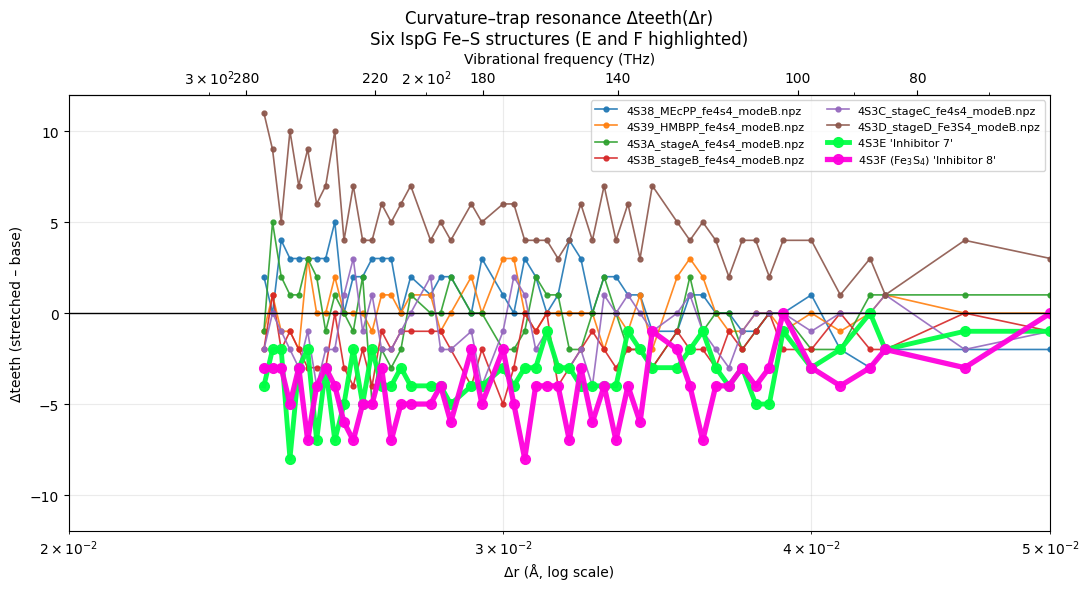

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------
# Ensure correct Δr column name regardless of JSON schema
# --------------------------------------------------------
if "Δr" in df_all.columns:
    dr_col = "Δr"
elif "Delta_r_A" in df_all.columns:
    dr_col = "Delta_r_A"
else:
    raise KeyError("Could not find Δr column in df_all")

# --------------------------------------------------------
# THz conversion functions (same as Fig. 5)
# --------------------------------------------------------
def dr_to_thz(dr_A):
    hbar = 1.054e-34
    u    = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS) * u
    A = dr_A * 1e-10
    nu = hbar / (2*m_r*A*A)
    return nu/1e12

def thz_to_dr(thz):
    hbar = 1.054e-34
    u    = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS) * u
    nu = thz * 1e12
    A = np.sqrt(hbar/(2*m_r*nu))
    return A * 1e10

# --------------------------------------------------------
# Key curve tags
# --------------------------------------------------------
F_tag = "4S3F_stageF_Fe3S4_modeB.npz"
E_tag = "4S3E_inhib7_fe4s4_modeB.npz"

plt.figure(figsize=(11,6))

# --------------------------------------------------------
# Plot all Δteeth curves
# --------------------------------------------------------
for tag in df_all["file"].unique():
    sub = df_all[df_all["file"] == tag].sort_values(dr_col)

    # Highlight F (collapsed Fe3S4)
    if tag == F_tag:
        plt.plot(
            sub[dr_col], sub["Δteeth"],
            "-o",
            lw=3.8,
            ms=7,
            color="#ff00dd",        # bright pink
            alpha=0.95,
            label="4S3F (Fe$_3$S$_4$) 'Inhibitor 8'"
        )

    # Highlight E (inhibitor Fe4S4)
    elif tag == E_tag:
        plt.plot(
            sub[dr_col], sub["Δteeth"],
            "-o",
            lw=3.5,
            ms=7,
            color="#00ff44",        # bright lime
            alpha=0.95,
            label="4S3E 'Inhibitor 7'"
        )

    # Other curves (full color, thin)
    else:
        plt.plot(
            sub[dr_col], sub["Δteeth"],
            "-o",
            lw=1.2,
            ms=3.5,
            alpha=0.90,
            label=tag
        )

# --------------------------------------------------------
# Formatting (match Fig. 5)
# --------------------------------------------------------
plt.axhline(0, color="k", lw=1)

plt.xscale("log")
plt.xlim(2e-2, 5e-2)        # === same Δr window as Fig 5 (0.02–0.035 Å)

plt.ylim(-12, 12)
plt.xlabel("Δr (Å, log scale)")
plt.ylabel("Δteeth (stretched – base)")
plt.title("Curvature–trap resonance Δteeth(Δr)\nSix IspG Fe–S structures (E and F highlighted)")

plt.grid(True, which="both", alpha=0.25)

# --------------------------------------------------------
# Add THz axis (upper x-axis)
# --------------------------------------------------------
ax = plt.gca()
ax2 = ax.secondary_xaxis("top", functions=(dr_to_thz, thz_to_dr))

thz_ticks = [20, 40, 60, 80, 100, 140, 180, 220, 280]
ax2.set_xticks(thz_ticks)
ax2.set_xticklabels([f"{v}" for v in thz_ticks])
ax2.set_xlabel("Vibrational frequency (THz)")

plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

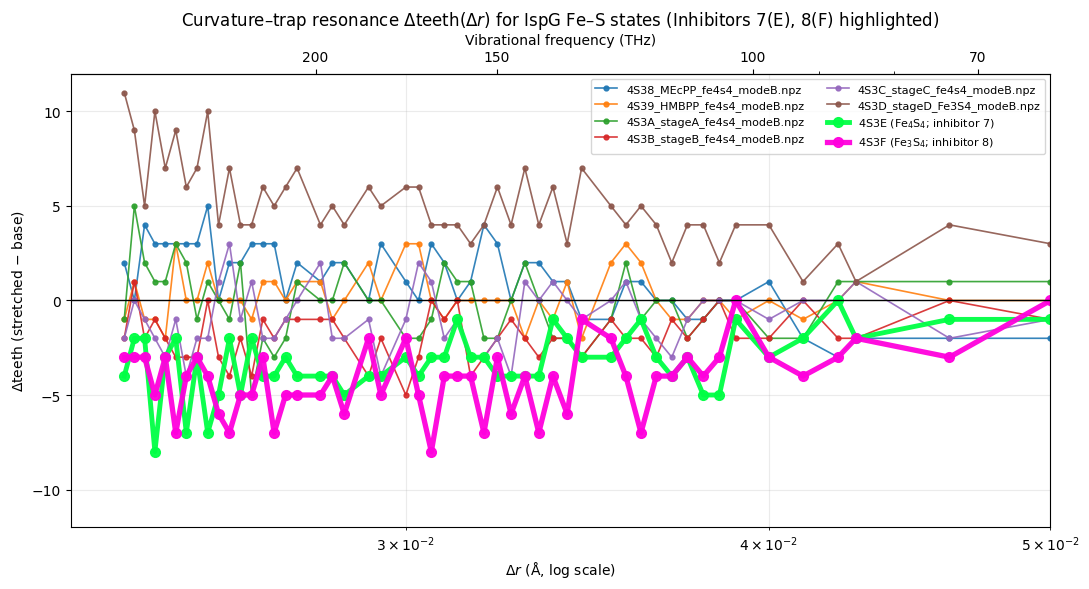

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------
# Ensure correct Δr column name regardless of JSON schema
# --------------------------------------------------------
if "Δr" in df_all.columns:
    dr_col = "Δr"
elif "Delta_r_A" in df_all.columns:
    dr_col = "Delta_r_A"
else:
    raise KeyError("Could not find Δr column in df_all")

# --------------------------------------------------------
# THz conversion functions (same as in Fig. 5), with zero-safe inverse
# --------------------------------------------------------
def dr_to_thz(dr_A):
    hbar = 1.054e-34      # J·s
    u    = 1.6605e-27     # kg (atomic mass unit)
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS) * u  # reduced mass in kg
    A = np.asarray(dr_A, dtype=float) * 1e-10  # Å → m
    nu = hbar / (2.0 * m_r * A * A)            # Hz
    return nu / 1e12                           # THz

def thz_to_dr(thz):
    # Inverse of dr_to_thz, with protection against nu = 0
    hbar = 1.054e-34
    u    = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS) * u
    nu = np.asarray(thz, dtype=float) * 1e12   # THz → Hz
    # avoid division by zero at nu = 0 by setting to NaN (ignored in ticks)
    nu_safe = np.where(nu == 0.0, np.nan, nu)
    A = np.sqrt(hbar / (2.0 * m_r * nu_safe))  # m
    return A * 1e10                            # Å

# --------------------------------------------------------
# Key curve tags
# --------------------------------------------------------
F_tag = "4S3F_stageF_Fe3S4_modeB.npz"
E_tag = "4S3E_inhib7_fe4s4_modeB.npz"

plt.figure(figsize=(11, 6))

# --------------------------------------------------------
# Plot all Δteeth curves
# --------------------------------------------------------
for tag in df_all["file"].unique():
    sub = df_all[df_all[ "file" ] == tag].sort_values(dr_col)

    if tag == F_tag:
        # Highlight F (Fe3S4 inhibitory endpoint)
        plt.plot(
            sub[dr_col], sub["Δteeth"],
            "-o",
            lw=3.8,
            ms=7,
            color="#ff00dd",   # bright magenta
            alpha=0.95,
            label="4S3F (Fe$_3$S$_4$; inhibitor 8)"
        )

    elif tag == E_tag:
        # Highlight E (Fe4S4 + inhibitor 7)
        plt.plot(
            sub[dr_col], sub["Δteeth"],
            "-o",
            lw=3.5,
            ms=7,
            color="#00ff44",   # bright lime
            alpha=0.95,
            label="4S3E (Fe$_4$S$_4$; inhibitor 7)"
        )

    else:
        # All other curves normal, full colour but thinner
        plt.plot(
            sub[dr_col], sub["Δteeth"],
            "-o",
            lw=1.2,
            ms=3.5,
            alpha=0.90,
            label=tag
        )

# --------------------------------------------------------
# Formatting (match Fig. 5 Δr window & style)
# --------------------------------------------------------
plt.axhline(0, color="k", lw=1)

# Δr axis in Å, log scale, 0.020–0.035 Å (2.0e-2–3.5e-2)
plt.xscale("log")
plt.xlim(2.3e-2, 5e-2)

plt.ylim(-12, 12)
plt.xlabel(r"$\Delta r$ (Å, log scale)")
plt.ylabel(r"$\Delta\mathrm{teeth}$ (stretched $-$ base)")
plt.title(r"Curvature–trap resonance $\Delta\mathrm{teeth}(\Delta r)$ "
          r"for IspG Fe–S states (Inhibitors 7(E), 8(F) highlighted)")

plt.grid(True, which="both", alpha=0.25)

# --------------------------------------------------------
# Add THz axis (upper x-axis), same mapping as Fig. 5
# --------------------------------------------------------
ax = plt.gca()
ax2 = ax.secondary_xaxis("top", functions=(dr_to_thz, thz_to_dr))

# Choose THz ticks that roughly span 30–200 THz (you can tweak as needed)
thz_ticks = [30, 50, 70, 100, 150, 200, 300]
ax2.set_xticks(thz_ticks)
ax2.set_xticklabels([f"{v}" for v in thz_ticks])
ax2.set_xlabel("Vibrational frequency (THz)")

plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from pathlib import Path

BASE_DIR = Path("/content")
TEETH_DIR = BASE_DIR / "teethnpz"
TEETH_DIR.mkdir(exist_ok=True)

def make_comb_npz_from_def2(label, base_npz_name, dist_npz_name, out_name):
    base = np.load(BASE_DIR / base_npz_name, allow_pickle=True)
    dist = np.load(BASE_DIR / dist_npz_name, allow_pickle=True)

    kappa_base = np.abs(base["laplacian"].ravel())
    kappa_mode = np.abs(dist["laplacian"].ravel())

    np.savez(
        TEETH_DIR / out_name,
        kappa_base=kappa_base,
        kappa_mode=kappa_mode,
        tag=label,
    )
    print("Wrote comb NPZ:", TEETH_DIR / out_name)

# 4S39 active (HMBPP) def2-SVP
make_comb_npz_from_def2(
    label="4S39_active_def2svp",
    base_npz_name="4S39_active_base_def2svp.npz",
    dist_npz_name="4S39_active_modeB_def2svp.npz",
    out_name="4S39_active_def2svp_comb.npz",
)

# 4S3E inhibitor 7 def2-SVP
make_comb_npz_from_def2(
    label="4S3E_inhib7_def2svp",
    base_npz_name="4S3E_inhib7_base_def2svp.npz",
    dist_npz_name="4S3E_inhib7_modeB_def2svp.npz",
    out_name="4S3E_inhib7_def2svp_comb.npz",
)

FileNotFoundError: [Errno 2] No such file or directory: '/content/4S39_active_base_def2svp.npz'